In [1]:
import requests
import numpy as np
import dask
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import re
import json
import nltk

from bs4 import BeautifulSoup
from tqdm import tqdm_notebook as tqdm
from dask import delayed
from dask.diagnostics import ProgressBar
from datetime import datetime
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

ProgressBar().register()

In [2]:
class FoodPandaScraper():
    
    def __init__(self):
        pass
    
    def get_page_reviews(self, page):
        return page.find_all("div", class_="review-component hreview")
    
    def parse_review(self, review):
        return {
            'date': review.select_one('.review-date.dtreviewed').get('title'),
            'vendor': review.select_one('.vendor-name.vcard.item .fn').text.strip(),
            'description': review.select_one('.description').text.strip(),
            'rating': float(review.select_one('.rating').text.split('/')[0])
        }
    
    def parse(self, url):
        response = requests.get(url)
        html = response.text
        page = BeautifulSoup(html, 'html.parser')
        reviews = self.get_page_reviews(page)        
        metadata = json.loads(page.select_one('.where-wrapper').get('data-vendor'))

        def parse_delivery_time(t):
            return re.sub('\s+', ' ', t.text.strip())

        return {
            'url': url,
            'vendor': page.select_one('.vendor-info-main-headline.item .fn').text,
            'rating': float(page.select_one('.ratings-component .rating').text.split('/')[0]),
            'count': int(int(page.select_one('.ratings-component .count').text.strip())),
            'tags': list(map(lambda x: x.text, page.select_one(".vendor-info-main-details-cuisines") \
                                                   .find_all('li', {'data-id': True}))),
            'reviews': list(map(self.parse_review, reviews)),
            'address': page.select_one('.vendor-location').text,
            'delivery_time': list(map(parse_delivery_time, page.select('.vendor-delivery-times li'))),
            'longitude': metadata['longitude'],
            'latitude': metadata['latitude']
        }
    
    @staticmethod
    def get_vendor_links(url):
        response = requests.get(url)
        html = response.text
        soup = BeautifulSoup(html, 'html.parser')
        
        links = ['https://www.foodpanda.sg' + link.get('href') 
                 for link in soup.find_all('a', {'data-vendor-id': True})]
        if links:
            return links
        
        links = [link.get('href') for link in soup.select('a.hreview-aggregate.url')]
        return links

In [3]:
FoodPandaScraper().parse('https://www.foodpanda.sg/restaurant/y5vr/126-dim-sum-wen-dao-shi')

{'address': '126 Sims Avenue, 387449 Singapore',
 'count': 264,
 'delivery_time': ['Mon - Sun 12:00 am - 11:59 pm, 12:00 am - 11:59 pm'],
 'latitude': 1.314149,
 'longitude': 103.878395,
 'rating': 4.5,
 'reviews': [{'date': '2020-05-23',
   'description': 'Good restaurant.',
   'rating': 4.0,
   'vendor': '126 Dim Sum Wen Dao Shi'},
  {'date': '2020-05-23',
   'description': 'Great! Thank you!',
   'rating': 5.0,
   'vendor': '126 Dim Sum Wen Dao Shi'},
  {'date': '2020-05-20',
   'description': 'Good food',
   'rating': 5.0,
   'vendor': '126 Dim Sum Wen Dao Shi'},
  {'date': '2020-05-18',
   'description': 'Good food',
   'rating': 4.0,
   'vendor': '126 Dim Sum Wen Dao Shi'},
  {'date': '2020-05-16',
   'description': 'Amazingl food',
   'rating': 5.0,
   'vendor': '126 Dim Sum Wen Dao Shi'},
  {'date': '2020-05-11',
   'description': 'Pls give more chilli next time, one small pack is not enough for 3 x dim sum. Tq',
   'rating': 3.0,
   'vendor': '126 Dim Sum Wen Dao Shi'},
  {'da

In [4]:
response = requests.get('https://www.foodpanda.sg')
html = response.text
soup = BeautifulSoup(html, 'html.parser')

vendor_links = set(
    [a_element.get('href') for a_element in 
        soup.select('.footer__popular a') + \
        soup.select('.PopularChains a')] + \
    np.sum([FoodPandaScraper.get_vendor_links(vendor_link.get('href')) 
         for vendor_link in soup.select('.home-cuisines__list__item a')]) + \
    FoodPandaScraper.get_vendor_links('https://www.foodpanda.sg/city/singapore'))

len(vendor_links)

781

# Download Data

In [5]:
def extract_data(url):
    try:
        return FoodPandaScraper().parse(url)
    except:
        return {}

items = [delayed(extract_data)(url) for url in vendor_links]
fp_datas = dask.compute(*items)

[########################################] | 100% Completed |  4min 52.5s


In [6]:
with open('foodpanda_data.json', 'w') as outfile:
    json.dump(fp_datas, outfile)

# Create DataFrame

In [7]:
df = pd.DataFrame(fp_datas).dropna()
df['count'] = df['count'].astype(int)
df['n_reviews'] = df['reviews'].apply(len)
df['postal_code'] = df['address'].apply(lambda x: re.search('\d{6}', x).group(0))
df.head()

,url,vendor,rating,count,tags,reviews,address,delivery_time,longitude,latitude,n_reviews,postal_code
0,https://www.foodpanda.sg/chain/cq9ep/manhattan...,The Manhattan FISH MARKET,4.3,2452,"[Halal, Seafood, Western, American, Halal]","[{'date': '2020-05-25', 'vendor': 'The Manhatt...","930 Yishun Avenue 2, Northpoint City North Win...","[Mon - Sun 11:30 am - 8:30 pm, 11:30 am - 8:30...",103.835786,1.429581,50,769098
1,https://www.foodpanda.sg/restaurant/s6ov/la-salsa,La Salsa,4.2,327,"[American, Western, Mexican, Tacos, Burritos]","[{'date': '2020-05-23', 'vendor': 'La Salsa', ...","#01-17, 11 Dempsey Road, West Central, Dempsey...","[Tue - Sun 12:00 pm - 11:00 pm, 12:00 pm - 11:...",103.809975,1.304210,18,249673
2,https://www.foodpanda.sg/restaurant/w4iv/kfc-r...,KFC (Rivervale Mall),4.2,1162,"[American, Burgers, Chicken, Halal, Western]","[{'date': '2020-05-29', 'vendor': 'KFC (Riverv...","11 Rivervale Crescent, Rivervale Mall, #01-35,...",[Mon - Sun 7:30 am - 10:00 pm],103.904352,1.392262,50,545082
3,https://www.foodpanda.sg/restaurant/v6bq/makis...,MakiSan (Junction 8),4.6,2830,"[Halal, Healthy, Sushi, Japanese, Halal]","[{'date': '2020-05-27', 'vendor': 'MakiSan (Ju...","02-27A, 9 Bishan Place, Junction 8, Bishan, An...","[Mon - Sun 10:30 am - 9:00 pm, 10:30 am - 9:00...",103.848324,1.350375,49,579837
4,https://www.foodpanda.sg/restaurant/w3dv/al-ha...,Al Hadheerah Indian Muslim & Thai Seafood Rest...,4.1,219,"[Thai, Indian, Curry, Hawker Favourites]","[{'date': '2020-05-10', 'vendor': 'Al Hadheera...","#B1-01 HDB Hub, 480 Lorong 6 Toa Payoh, 310480...","[Mon - Sun 11:00 am - 9:00 pm, 11:00 am - 9:00...",103.848537,1.332342,31,310480


# Combine tags into single string

In [8]:
df['tags'] = df['tags'].apply(lambda tokens: ','.join([token.replace(' ', '_') for token in tokens]))
df.head()

,url,vendor,rating,count,tags,reviews,address,delivery_time,longitude,latitude,n_reviews,postal_code
0,https://www.foodpanda.sg/chain/cq9ep/manhattan...,The Manhattan FISH MARKET,4.3,2452,"Halal,Seafood,Western,American,Halal","[{'date': '2020-05-25', 'vendor': 'The Manhatt...","930 Yishun Avenue 2, Northpoint City North Win...","[Mon - Sun 11:30 am - 8:30 pm, 11:30 am - 8:30...",103.835786,1.429581,50,769098
1,https://www.foodpanda.sg/restaurant/s6ov/la-salsa,La Salsa,4.2,327,"American,Western,Mexican,Tacos,Burritos","[{'date': '2020-05-23', 'vendor': 'La Salsa', ...","#01-17, 11 Dempsey Road, West Central, Dempsey...","[Tue - Sun 12:00 pm - 11:00 pm, 12:00 pm - 11:...",103.809975,1.304210,18,249673
2,https://www.foodpanda.sg/restaurant/w4iv/kfc-r...,KFC (Rivervale Mall),4.2,1162,"American,Burgers,Chicken,Halal,Western","[{'date': '2020-05-29', 'vendor': 'KFC (Riverv...","11 Rivervale Crescent, Rivervale Mall, #01-35,...",[Mon - Sun 7:30 am - 10:00 pm],103.904352,1.392262,50,545082
3,https://www.foodpanda.sg/restaurant/v6bq/makis...,MakiSan (Junction 8),4.6,2830,"Halal,Healthy,Sushi,Japanese,Halal","[{'date': '2020-05-27', 'vendor': 'MakiSan (Ju...","02-27A, 9 Bishan Place, Junction 8, Bishan, An...","[Mon - Sun 10:30 am - 9:00 pm, 10:30 am - 9:00...",103.848324,1.350375,49,579837
4,https://www.foodpanda.sg/restaurant/w3dv/al-ha...,Al Hadheerah Indian Muslim & Thai Seafood Rest...,4.1,219,"Thai,Indian,Curry,Hawker_Favourites","[{'date': '2020-05-10', 'vendor': 'Al Hadheera...","#B1-01 HDB Hub, 480 Lorong 6 Toa Payoh, 310480...","[Mon - Sun 11:00 am - 9:00 pm, 11:00 am - 9:00...",103.848537,1.332342,31,310480


# Duplicated Data

In [9]:
duplicated_vendors = list(df.vendor.value_counts().where(lambda x: x>1).dropna().index)
duplicated_data = df[df['vendor'].isin(duplicated_vendors)].sort_values('vendor')

display(duplicated_data.head())

for url in duplicated_data['url']:
    print(url)

,url,vendor,rating,count,tags,reviews,address,delivery_time,longitude,latitude,n_reviews,postal_code
602,https://www.foodpanda.sg/restaurant/s3uq/bales...,Balestier Bak Kut Teh,4.4,1141,"Seafood,Singaporean,Vegetarian,Chinese,Soup","[{'date': '2020-05-26', 'vendor': 'Balestier B...","365 Balestier Road, Upper central, 329785 Sing...","[Mon - Sun 12:00 am - 11:59 pm, 12:00 am - 11:...",103.850594,1.324881,40,329785
445,https://www.foodpanda.sg/chain/ca4oz/balestier...,Balestier Bak Kut Teh,4.4,1141,"Seafood,Singaporean,Vegetarian,Chinese,Soup","[{'date': '2020-05-26', 'vendor': 'Balestier B...","365 Balestier Road, Upper central, 329785 Sing...","[Mon - Sun 12:00 am - 11:59 pm, 12:00 am - 11:...",103.850594,1.324881,40,329785
96,https://www.foodpanda.sg/chain/cs3bp/crystal-j...,Crystal Jade Hong Kong Kitchen,4.5,877,"Singaporean,Asian,Chinese,Dim_Sum,Rice","[{'date': '2020-05-10', 'vendor': 'Crystal Jad...","B2-38, 391 Orchard Road, Ngee Ann City, River ...","[Mon - Sun 11:00 am - 9:00 pm, 11:00 am - 9:00...",103.834264,1.302965,29,238872
283,https://www.foodpanda.sg/chain/cs3bp/crystal-j...,Crystal Jade Hong Kong Kitchen,4.5,877,"Singaporean,Asian,Chinese,Dim_Sum,Rice","[{'date': '2020-05-10', 'vendor': 'Crystal Jad...","B2-38, 391 Orchard Road, Ngee Ann City, River ...","[Mon - Sun 11:00 am - 9:00 pm, 11:00 am - 9:00...",103.834264,1.302965,29,238872
563,https://www.foodpanda.sg/chain/ck5of/hansang-k...,Hansang Korean Family Restaurant,4.5,1884,"Seafood,Korean,Soup,Hotpot-Steamboat","[{'date': '2020-05-26', 'vendor': 'Hansang Kor...","10 Sinaran Drive #03-33, 307506 Singapore","[Mon - Sat 11:30 am - 9:30 pm, Sun 11:30 am - ...",103.844106,1.321112,49,307506


https://www.foodpanda.sg/restaurant/s3uq/balestier-bak-kut-teh-1
https://www.foodpanda.sg/chain/ca4oz/balestier-bak-kut-teh
https://www.foodpanda.sg/chain/cs3bp/crystal-jade-hong-kong-kitchen
https://www.foodpanda.sg/chain/cs3bp/crystal-jade-kitchen
https://www.foodpanda.sg/chain/ck5of/hansang-korean-family-restaurant
https://www.foodpanda.sg/restaurant/s9ku/hansang-korean-family-restaurant
https://www.foodpanda.sg/restaurant/w2ou/hanuman-thai-cuisine-1
https://www.foodpanda.sg/chain/cs2kr/hanuman-thai-cuisine
https://www.foodpanda.sg/restaurant/v5kv/in-piazza-italian-restaurant-and-pizzeria
https://www.foodpanda.sg/chain/ca5xk/in-piazza-italian-restaurant-and-pizzeria
https://www.foodpanda.sg/chain/cc5kh/kin-moo
https://www.foodpanda.sg/restaurant/x1fs/kin-moo
https://www.foodpanda.sg/restaurant/s3ml/miam-miam-bugis-junction-
https://www.foodpanda.sg/restaurant/s3ml/miam-miam-bugis-junction
https://www.foodpanda.sg/chain/cc0or/sinn-ji-hainanese-chicken-rice
https://www.foodpanda.sg/re

In [10]:
df.shape

(743, 12)

In [11]:
df_clean = df.groupby('vendor', as_index=False).apply(lambda x: x.head(1)).reset_index(drop=True)
print(df_clean.shape)
df_clean.head()

(733, 12)


,url,vendor,rating,count,tags,reviews,address,delivery_time,longitude,latitude,n_reviews,postal_code
0,https://www.foodpanda.sg/chain/cy8fh/fulee-sea...,Fulee Seafood,4.5,4,,[],"265 BUKIT BATOK EAST AVE 4 #01-405, 650265 Sin...","[Mon - Sun 11:30 am - 10:30 pm, 11:30 am - 10:...",103.759565,1.350046,0,650265
1,https://www.foodpanda.sg/restaurant/y9tg/116-y...,116 Yong Tau Foo,4.2,10,Chinese,"[{'date': '2020-05-03', 'vendor': '116 Yong Ta...","116 Toa Payoh Lorong 2 #01-140, 310116 Singapore","[Mon - Sun 8:00 am - 7:30 pm, 8:00 am - 7:30 pm]",103.846087,1.340441,3,310116
2,https://www.foodpanda.sg/restaurant/x8qb/183-f...,183 Fishball Noodle,4.3,118,"Singaporean,Noodles,Fish","[{'date': '2020-05-12', 'vendor': '183 Fishbal...","183 Toa Payoh Central 01-316, 310183 Singapore","[Mon - Sun 8:30 am - 9:30 pm, 8:30 am - 9:30 pm]",103.848844,1.333365,11,310183
3,https://www.foodpanda.sg/restaurant/d3az/21-on...,21 on Rajah,5.0,4,"Asian,Halal,Mediterranean",[],"1 Jln Rajah, 329133 Singapore","[Mon - Sun 10:00 am - 9:30 pm, 10:00 am - 9:30...",103.847462,1.327048,0,329133
4,https://www.foodpanda.sg/restaurant/v9hj/470-m...,470 Mini Wok,4.4,1703,"Thai,Malaysian,Halal,Chinese,Halal","[{'date': '2020-05-25', 'vendor': '470 Mini Wo...","#02-70, 470 Toa Payoh Lor 6, Toa Payoh, Ang Mo...","[Mon - Fri 10:30 am - 9:00 pm, 10:30 am - 9:00...",103.849342,1.332046,50,310470


# Descriptive Analysis

C:\Users\ChiaWei\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


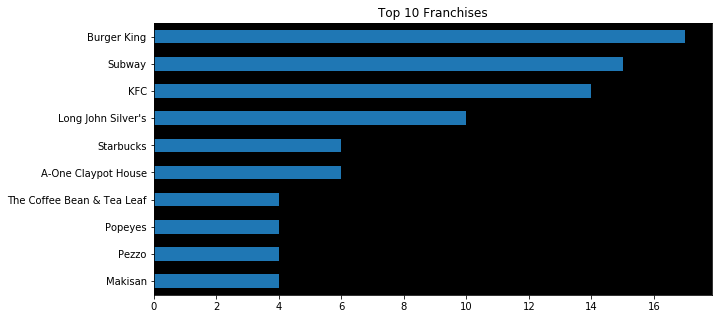

,url,vendor,rating,count,tags,reviews,address,delivery_time,longitude,latitude,n_reviews,postal_code,franchise
0,https://www.foodpanda.sg/chain/cy8fh/fulee-sea...,Fulee Seafood,4.5,4,,[],"265 BUKIT BATOK EAST AVE 4 #01-405, 650265 Sin...","[Mon - Sun 11:30 am - 10:30 pm, 11:30 am - 10:...",103.759565,1.350046,0,650265,None
1,https://www.foodpanda.sg/restaurant/y9tg/116-y...,116 Yong Tau Foo,4.2,10,Chinese,"[{'date': '2020-05-03', 'vendor': '116 Yong Ta...","116 Toa Payoh Lorong 2 #01-140, 310116 Singapore","[Mon - Sun 8:00 am - 7:30 pm, 8:00 am - 7:30 pm]",103.846087,1.340441,3,310116,None
2,https://www.foodpanda.sg/restaurant/x8qb/183-f...,183 Fishball Noodle,4.3,118,"Singaporean,Noodles,Fish","[{'date': '2020-05-12', 'vendor': '183 Fishbal...","183 Toa Payoh Central 01-316, 310183 Singapore","[Mon - Sun 8:30 am - 9:30 pm, 8:30 am - 9:30 pm]",103.848844,1.333365,11,310183,None
3,https://www.foodpanda.sg/restaurant/d3az/21-on...,21 on Rajah,5.0,4,"Asian,Halal,Mediterranean",[],"1 Jln Rajah, 329133 Singapore","[Mon - Sun 10:00 am - 9:30 pm, 10:00 am - 9:30...",103.847462,1.327048,0,329133,None
4,https://www.foodpanda.sg/restaurant/v9hj/470-m...,470 Mini Wok,4.4,1703,"Thai,Malaysian,Halal,Chinese,Halal","[{'date': '2020-05-25', 'vendor': '470 Mini Wo...","#02-70, 470 Toa Payoh Lor 6, Toa Payoh, Ang Mo...","[Mon - Fri 10:30 am - 9:00 pm, 10:30 am - 9:00...",103.849342,1.332046,50,310470,None


In [12]:
franchises = set()
for vendor in df_clean['vendor']:
    num_franchises = df_clean['vendor'].str.startswith(vendor).sum()
    if num_franchises > 1:
        franchises.add(vendor)

df_clean['franchise'] = None
for name in franchises:
    df_clean['franchise'][df_clean['vendor'].str.startswith(name)] = name
    
fig, ax = plt.subplots(figsize=(10, 5))
df_clean['franchise'].dropna().value_counts(ascending=False)[:10].plot.barh(ax=ax)
ax.invert_yaxis()
ax.set_facecolor('black')
ax.set_title('Top 10 Franchises')
plt.show()

df_clean.head()

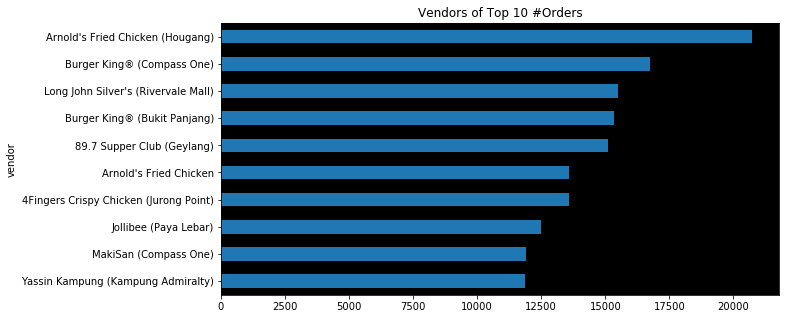

In [13]:
fig, ax = plt.subplots(figsize=(10, 5))
df_clean.sort_values('count', ascending=False).set_index('vendor')['count'][:10].plot.barh(ax=ax)
ax.invert_yaxis()
ax.set_facecolor('black')
ax.set_title('Vendors of Top 10 #Orders')
plt.show()

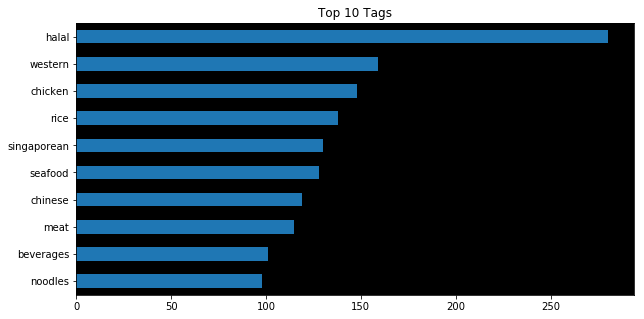

,0_mov,8th_birthday,_baby,_nyonya,alcohol,american,asian,bakery_and_cakes,bbq,bbt,...,tea_time,thai,top_rated,turkish,vegan,vegetarian,vietnamese,western,wraps,yogurt
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


In [14]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()
X = vectorizer.fit_transform(df_clean['tags']).toarray()

df_tags = pd.DataFrame(X, columns=vectorizer.get_feature_names())

fig, ax = plt.subplots(figsize=(10, 5))
df_tags.sum().sort_values(ascending=False)[:10].plot.barh(ax=ax)
ax.invert_yaxis()
ax.set_facecolor('black')
ax.set_title('Top 10 Tags')
plt.show()

display(df_tags.head())

In [15]:
df_reviews = pd.DataFrame(df_clean['reviews'].sum()).dropna()
df_reviews['date'] = pd.to_datetime(df_reviews['date'])
df_reviews.head()

,date,vendor,description,rating
0,2020-05-03,116 Yong Tau Foo,Really fast and packed the food well... even t...,5.0
1,2020-04-28,116 Yong Tau Foo,This for the ice for my coke 👍👍👍,5.0
2,2020-04-20,116 Yong Tau Foo,I had mentioned to add kwetiau but they didn’t...,3.0
3,2020-05-12,183 Fishball Noodle,Super nice and huge portion !,5.0
4,2020-04-15,183 Fishball Noodle,Was not what I requested,1.0


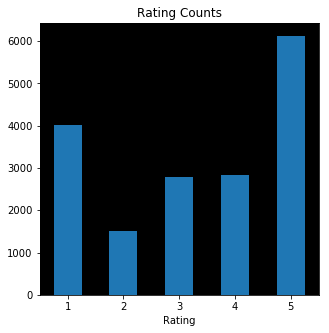

In [16]:
fig, ax = plt.subplots(figsize=(5, 5))
df_reviews.rating.astype(int).value_counts().sort_index().plot.bar(ax=ax, rot=0)
ax.set_facecolor('black')
ax.set_title('Rating Counts')
ax.set_xlabel('Rating')
plt.show()

# Tags Analysis

In [17]:
tag_to_info = {k: f'{k}({v})' for k, v in df_tags.sum().to_dict().items()}

df_tags_lookup = pd.DataFrame({
    'tag': df_tags.columns
})
df_tags_lookup['tag'] = df_tags_lookup['tag'].map(tag_to_info)
df_tags_lookup['start'] = df_tags_lookup['tag'].str[0]

for t in df_tags_lookup.groupby('start').apply(lambda x: ','.join(x['tag'])):
    print(t[0] + ': ' + t)

0: 0_mov(1)
8: 8th_birthday(2)
_: _baby(1),_nyonya(1)
a: alcohol(8),american(78),asian(67)
b: bakery_and_cakes(42),bbq(3),bbt(3),bento(9),beverages(101),breakfast(39),bubble_tea(5),burgers(68),burritos(6)
c: chicken(148),chinese(119),citibank_deal(6),curry(18)
d: dessert(74),dim_sum(13),dinner(20),drinks(8)
e: european(11),everyday_favourites(5)
f: fast_food(27),favourites_by_foodpanda(1),filipino(1),fish(31),flash_sale(5),flowers(2),french(13),fruits(11),fusion(4)
g: greek(1),groceries(2)
h: halal(280),hawker_favourites(10),hawker_legends(1),healthy(59),hot_deals(1),hotpot(4),huat(50)
i: ice_cream(13),indian(36),indonesian(13),international(6),italian(33)
j: japanese(61),june_deals(10)
k: korean(24)
l: late_night_delivery(20),lebanese(3),local_heroes(15),lunch(46)
m: malay(10),malaysian(12),meat(115),mediterranean(9),mexican(12),middle_eastern(17),mother_(1),muslim(10)
n: noodles(98)
p: party_supplies(1),pasta(36),peranakan_(1),pizza(33),poke_bowl(8)
r: rice(138)
s: salad(34),sandwich

In [18]:
def query_by_tag(qry):
    df_qry = df_clean[df_clean.tags.str.lower().str.contains(qry.lower())]
    display(df_qry)
    
    for url in df_qry['url']:
        print(url)

In [19]:
query_by_tag('0_mov')

,url,vendor,rating,count,tags,reviews,address,delivery_time,longitude,latitude,n_reviews,postal_code,franchise
458,https://www.foodpanda.sg/chain/ct1mc/party-who...,Party Wholesale Centre,4.1,6,"Singaporean,Party_Supplies,Shops,$0_MOV,Huat","[{'date': '2019-06-16', 'vendor': 'Party Whole...","81 Frankel Avenue Singapore, 458209 Singapore","[Mon - Sun 9:00 am - 11:00 am, 2:00 pm - 5:00 ...",103.919079,1.315209,1,458209,None


https://www.foodpanda.sg/chain/ct1mc/party-wholesale-centre


In [20]:
query_by_tag('_baby')

,url,vendor,rating,count,tags,reviews,address,delivery_time,longitude,latitude,n_reviews,postal_code,franchise
404,https://www.foodpanda.sg/chain/cb7qd/mothercare,Mothercare,1.0,1,"Sandwiches,Mother_&_Baby,Shops,Huat","[{'date': '2020-03-17', 'vendor': 'Mothercare'...","80 Marine Parade Road #02-34B, Singapore, 4492...","[Mon - Sun 11:00 am - 9:30 pm, 11:00 am - 9:30...",103.905109,1.301097,1,449269,None


https://www.foodpanda.sg/chain/cb7qd/mothercare


In [21]:
query_by_tag('party_supplies')

,url,vendor,rating,count,tags,reviews,address,delivery_time,longitude,latitude,n_reviews,postal_code,franchise
458,https://www.foodpanda.sg/chain/ct1mc/party-who...,Party Wholesale Centre,4.1,6,"Singaporean,Party_Supplies,Shops,$0_MOV,Huat","[{'date': '2019-06-16', 'vendor': 'Party Whole...","81 Frankel Avenue Singapore, 458209 Singapore","[Mon - Sun 9:00 am - 11:00 am, 2:00 pm - 5:00 ...",103.919079,1.315209,1,458209,None


https://www.foodpanda.sg/chain/ct1mc/party-wholesale-centre


<span style='color:red;font-weight:bold'>Above are not foods!</span>

In [22]:
query_by_tag('8th_birthday')

,url,vendor,rating,count,tags,reviews,address,delivery_time,longitude,latitude,n_reviews,postal_code,franchise
71,https://www.foodpanda.sg/restaurant/v4ra/ben-j...,Ben & Jerry's and Magnum (Thomson Novena),4.8,157,"Dessert,Ice_Cream,Dinner,Tea_Time,8th_Birthday","[{'date': '2020-05-14', 'vendor': 'Ben & Jerry...","324 Thomson Road, Novena, Sembawang, Yishun, 3...","[Mon 6:00 am - 11:59 pm, 12:00 am - 6:00 am, 6...",103.842211,1.324182,6,307672,Ben & Jerry's and Magnum
702,https://www.foodpanda.sg/chain/cf8th/wok-hey,Wok Hey,4.6,232,"Halal,Singaporean,Local_Heroes,8th_Birthday,Ci...","[{'date': '2020-05-24', 'vendor': 'WOK HEY (AM...","53 Ang Mo Kio Ave 3 01-36, 569933 Singapore","[Mon - Sun 11:00 am - 9:45 pm, 11:00 am - 9:45...",103.848447,1.369541,23,569933,None


https://www.foodpanda.sg/restaurant/v4ra/ben-jerry-s-and-magnum-thomson-novena-
https://www.foodpanda.sg/chain/cf8th/wok-hey


<span style='color:red;font-weight:bold'>Whats 8th birthday? I googled but couldnt get anything meaningful</span>

In [23]:
query_by_tag('legend')

,url,vendor,rating,count,tags,reviews,address,delivery_time,longitude,latitude,n_reviews,postal_code,franchise
269,https://www.foodpanda.sg/restaurant/w1rb/inter...,International Muslim Food Stall Nasi Lemak,2.7,4,"Chicken,Seafood,Singaporean,Noodles,Hawker_Leg...",[],"01-03, 2 Changi Village Road, Changi Village M...","[Mon - Fri, Sun 4:30 pm - 11:30 pm, 4:30 pm - ...",103.988282,1.38919,0,500002,None


https://www.foodpanda.sg/restaurant/w1rb/international-muslim-food-stall-nasi-lemak


<span style='color:red;font-weight:bold'>The low orders and rating doesnt match with the legend word</span>

# Map Visualization (Size = #Orders, Color = Postal Code)

No handles with labels found to put in legend.


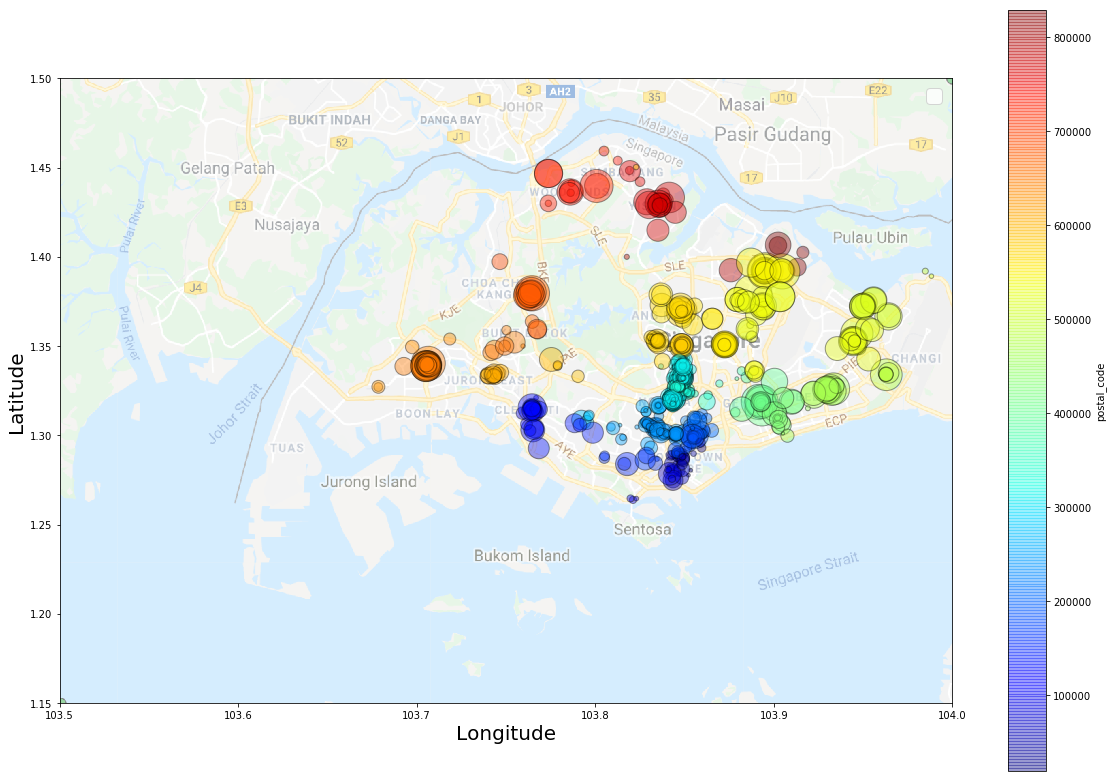

In [24]:
singapore_img = mpimg.imread('singapore-map-3.png')

data = df_clean.copy()
data['postal_code'] = data['postal_code'].apply(int)

ax = data.plot(
    kind="scatter", 
    x="longitude", 
    y="latitude", 
    figsize=(20,14),
    c="postal_code", 
    cmap=plt.get_cmap("jet"),
    colorbar=True, 
    alpha=0.4,
    s=data['count'].apply(lambda x: np.sqrt(x) * 10),
    edgecolor='black'
)

ax.imshow(singapore_img, extent=[103.5,104,1.15, 1.50], alpha=0.5)            

ax.set_ylabel("Latitude", fontsize=20)
ax.set_xlabel("Longitude", fontsize=20)

ax.set_ylim(1.15, 1.50)
ax.set_xlim(103.5, 104)
ax.legend(fontsize=20)
plt.show()

# Time Series Analysis

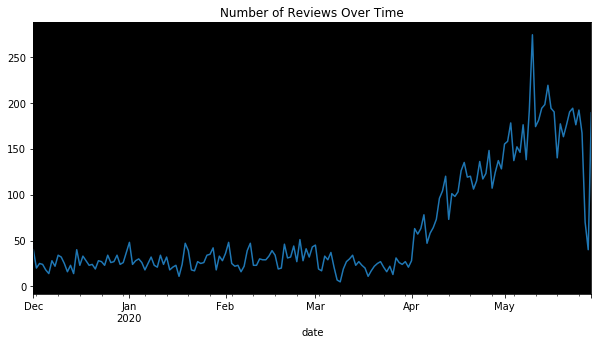

In [25]:
data = df_reviews
data = data[data['date'] >= datetime(2019, 12, 1)]
data = data.groupby('date').size().sort_index()

fig, ax = plt.subplots(figsize=(10, 5))
data.plot(ax=ax)
ax.set_facecolor('black')
ax.set_title('Number of Reviews Over Time')

plt.show()

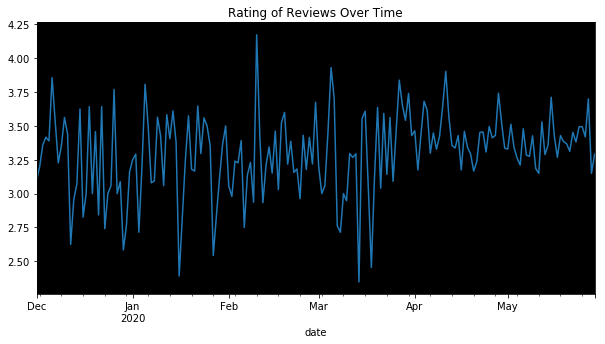

In [26]:
data = df_reviews
data = data[data['date'] >= datetime(2019, 12, 1)]
data = data.groupby('date')['rating'].mean().sort_index()

fig, ax = plt.subplots(figsize=(10, 5))
data.plot(ax=ax)
ax.set_facecolor('black')
ax.set_title('Rating of Reviews Over Time')

plt.show()

# Word Cloud

In [27]:
def generate_wordcloud(df_reviews, ratings):
    ##################
    # Create unigrams
    ##################
    def tokenize_description(desc):
        try:
            return np.sum([[t.lower() for t in nltk.word_tokenize(sent)] for sent in nltk.sent_tokenize(desc)])
        except:
            return []
    tokens = df_reviews[df_reviews['rating'].isin(ratings)]['description'].apply(tokenize_description).sum()

    stopword = stopwords.words('english')
    wordnet_lemmatizer = WordNetLemmatizer()
    tokens = [wordnet_lemmatizer.lemmatize(t) for t in tokens if t not in stopword]
    text = ' '.join(tokens)

    #################
    # Create bigrams
    #################
    bigram_tokens = [' '.join(t) for t in nltk.bigrams(tokens)]

    ############################
    # Create bigram frequencies
    ############################
    vectorizer = CountVectorizer(ngram_range=(2, 2))
    bag_of_words = vectorizer.fit_transform(bigram_tokens)

    sum_words = bag_of_words.sum(axis=0)
    word_freqs = {k: sum_words[0, v] for k, v in vectorizer.vocabulary_.items()}

    #####################
    # Create word clouds
    #####################
#     wordcloud = WordCloud(stopwords=set(STOPWORDS)).generate(text)

#     fig, ax = plt.subplots(figsize=(10, 6))
#     ax.imshow(wordcloud, interpolation='bilinear')
#     ax.axis("off")
#     ax.set_title(f'Unigram Word Cloud (Rating {rating})')
#     plt.show()

    wordcloud = WordCloud(stopwords=set(STOPWORDS))
    wordcloud.generate_from_frequencies(word_freqs)

    fig, ax = plt.subplots(figsize=(10, 6))
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.axis("off")
    ax.set_title(f'Bigram Word Cloud (Ratings {", ".join(map(str, ratings))})')
    plt.show()

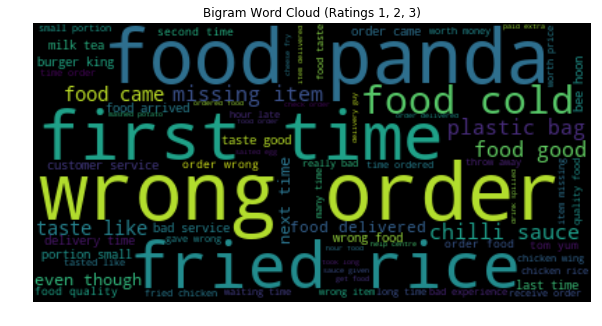

In [28]:
generate_wordcloud(df_reviews, [1,2,3])

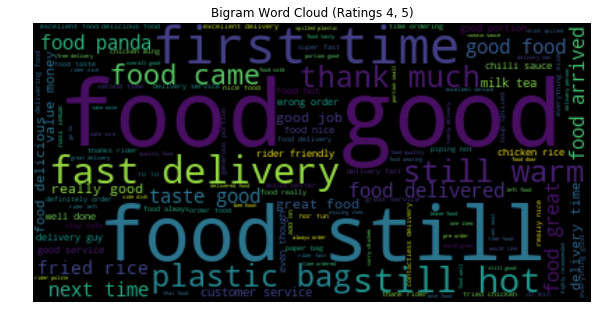

In [29]:
generate_wordcloud(df_reviews, [4,5])